In [148]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [149]:
df = pd.read_csv(r'D:\desktop\TaoBao_user_action.csv', encoding='ISO-8859-1')

In [150]:
df.head()

,user_id,item_id,behavior_type,item_category,time
0,98047837,232431562,1,4245,2024-12-06 02
1,97726136,383583590,1,5894,2024-12-09 20
2,98607707,64749712,1,2883,2024-12-18 11
3,98662432,320593836,1,6562,2024-12-06 10
4,98145908,290208520,1,13926,2024-12-16 21


In [151]:
print('Total number of rows: ', len(df))
print('Number of users: ', len(set(df['user_id'])))
print('Number of items: ', len(set(df['item_id'])))
print('Number of item categories: ', len(set(df['item_category'])))
print('Latest time: ', df['time'].max())
print('Earliest time: ', df['time'].min())

Total number of rows:  1048575
Number of users:  8477
Number of items:  701609
Number of item categories:  7095
Latest time:  2024-12-18 23
Earliest time:  2024-11-18 00


The dataset comprises detailed shopping behavior records of 10,000 users collected between November 18 and December 18, 2014, encompassing over 12.25 million transactions. It includes more than 2.87 million unique items across 8,916 categories. The dataset’s large scale and diversity provide a solid foundation for conducting robust data analysis and deriving meaningful insights.


<h2>Data cleaning</h2>

In [152]:
df.isnull().sum()

user_id          0
item_id          0
behavior_type    0
item_category    0
time             0
dtype: int64

No missing values are observed.

In [153]:
df['date'] = df['time'].map(lambda x: x.split(' ')[0])
df['hour'] = df['time'].map(lambda x: x.split(' ')[1])
df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].apply(lambda x: x.strftime('%A'))
df.head()

,user_id,item_id,behavior_type,item_category,time,date,hour,weekday
0,98047837,232431562,1,4245,2024-12-06 02,2024-12-06,02,Friday
1,97726136,383583590,1,5894,2024-12-09 20,2024-12-09,20,Monday
2,98607707,64749712,1,2883,2024-12-18 11,2024-12-18,11,Wednesday
3,98662432,320593836,1,6562,2024-12-06 10,2024-12-06,10,Friday
4,98145908,290208520,1,13926,2024-12-16 21,2024-12-16,21,Monday


In [154]:
df.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
item_category             int64
time                     object
date             datetime64[ns]
hour                     object
weekday                  object
dtype: object

In [155]:
df['user_id'] = df['user_id'].astype('object')
df['item_id'] = df['item_id'].astype('object')
df['item_category'] = df['item_category'].astype('object')
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['hour'].astype('int64')
df.dtypes

user_id                  object
item_id                  object
behavior_type             int64
item_category            object
time                     object
date             datetime64[ns]
hour                      int64
weekday                  object
dtype: object

<h2>User Visit Pattern Analysis</h2>

<h4>1. Daily Page Views (PV) and Unique Visitors (UV)</h4>

Text(0.5, 1.0, 'uv_daily')

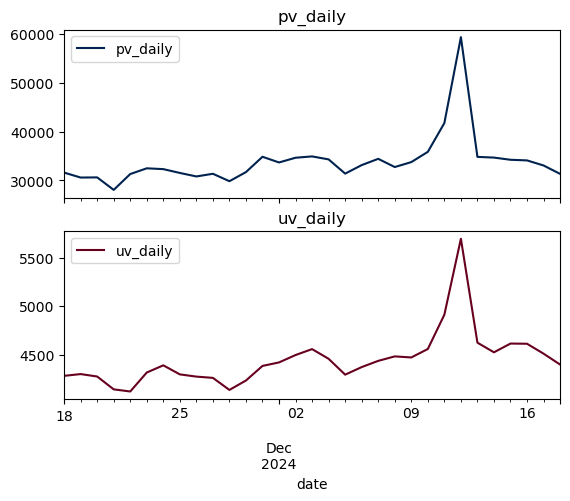

In [156]:
pv_daily = df.groupby('date')['user_id'].count().reset_index().rename(columns={
    'user_id': 'pv_daily'
})

uv_daily = df.groupby('date')['user_id'].apply(lambda x: x.drop_duplicates().count()).reset_index().rename(columns={
    'user_id': 'uv_daily'
})

pv_uv_daily = pd.merge(pv_daily, uv_daily, on='date', how='inner')

fig, axes = plt.subplots(2, 1, sharex=True)  
pv_daily.plot(x='date', y='pv_daily', ax=axes[0], colormap='cividis')
uv_daily.plot(x='date', y='uv_daily', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')

It can be observed that both pv_daily and uv_daily peaked on the 12th, which was driven by the “Double 12” online shopping festival.

(Note: November 11 — “Double 11” — and December 12 — “Double 12” — are two of China’s largest annual e-commerce sales events, similar to Black Friday in Australia.)

<h4>2. Hourly Page Views (PV) and Unique Visitors (UV) </h4>

Text(0.5, 1.0, 'uv_hour')

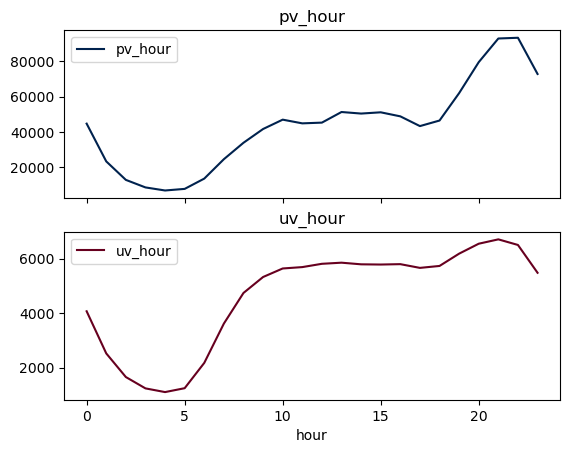

In [157]:
pv_hour = df.groupby('hour')['user_id'].count().reset_index().rename(columns={
    'user_id': 'pv_hour'
})

uv_hour = df.groupby('hour')['user_id'].apply(lambda x: x.drop_duplicates().count()).reset_index().rename(columns={
    'user_id': 'uv_hour'
})

pv_uv_hour = pd.merge(pv_hour, uv_hour, on='hour', how='inner')

fig, axes = plt.subplots(2, 1, sharex=True)  # subplots: 2 rows, 1 column, sharing the x-axis
pv_hour.plot(x='hour', y='pv_hour', ax=axes[0], colormap='cividis')
uv_hour.plot(x='hour', y='uv_hour', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')

It can be observed that user activity begins to increase after 10:00 a.m., with a noticeable concentration between **8:00 p.m. and 10:00 p.m.** This pattern may be explained by the fact that the majority of consumers are **working professionals** who tend to shop online after work.

<h4>3. Weekly Page Views (PV) and Unique Visitors (UV)</h4>

Text(0.5, 1.0, 'uv_weekday')

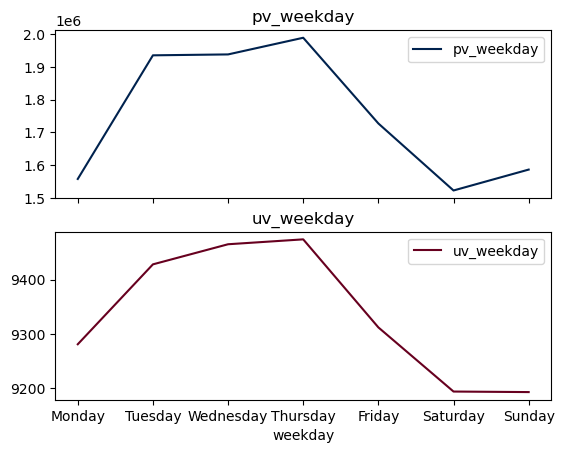

In [158]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

pv_weekday['weekday'] = pd.Categorical(pv_weekday['weekday'],
                                       categories=order, ordered=True)
uv_weekday['weekday'] = pd.Categorical(uv_weekday['weekday'],
                                       categories=order, ordered=True)

pv_weekday = pv_weekday.sort_values('weekday')
uv_weekday = uv_weekday.sort_values('weekday')

pv_uv_weekday = pd.merge(pv_weekday, uv_weekday, on='weekday', how='inner')


fig, axes = plt.subplots(2, 1, sharex=True)  # subplots: 2 rows, 1 column, sharing the x-axis
pv_weekday.plot(x='weekday', y='pv_weekday', ax=axes[0], colormap='cividis')
uv_weekday.plot(x='weekday', y='uv_weekday', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_weekday')
axes[1].set_title('uv_weekday')

It can be seen that Thursday has the highest weekly visit volume, followed by **Tuesday and Wednesday**. Traffic is relatively lower on **weekends and Monday**, likely because working professionals engage in a wider range of leisure and consumption activities on weekends, reducing their use of Taobao.

<h4>4.Comparison for the “Double 12” Event</h4>

From the trends of pv_daily and uv_daily, it can be observed that the total traffic on Double 12 shows a clear peak.
This raises the question: does user visit behavior, when analyzed on an hourly basis, also change significantly on Double 12?

In [159]:
df_1212 = df.loc[df['date'] == '2024-12-12']
df_1212.head()

,user_id,item_id,behavior_type,item_category,time,date,hour,weekday
13,101260672,212072908,1,10984,2024-12-12 11,2024-12-12,11,Thursday
20,101781721,19349307,1,1863,2024-12-12 12,2024-12-12,12,Thursday
54,100684618,94486594,1,10984,2024-12-12 23,2024-12-12,23,Thursday
69,103802946,190848347,1,5232,2024-12-12 22,2024-12-12,22,Thursday
95,104811265,354843735,1,10585,2024-12-12 21,2024-12-12,21,Thursday


Text(0.5, 1.0, 'uv_hour_1212')

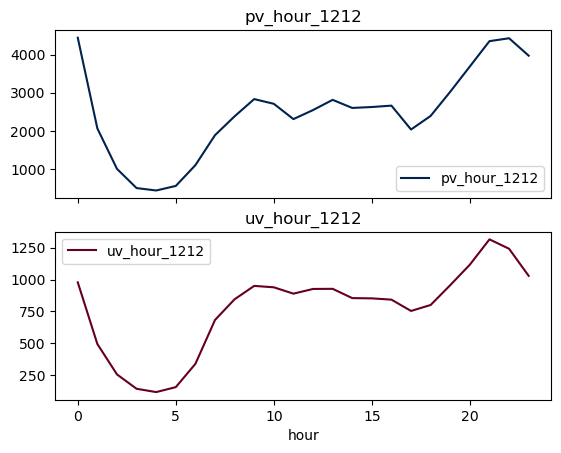

In [160]:
pv_hour_1212 = df_1212.groupby('hour')['user_id'].count().reset_index().rename(columns={
    'user_id': 'pv_hour_1212'
})

uv_hour_1212 = df_1212.groupby('hour')['user_id'].apply(lambda x: x.drop_duplicates().count()).reset_index().rename(columns={
    'user_id': 'uv_hour_1212'
})

pv_uv_hour_1212 = pd.merge(pv_hour_1212, uv_hour_1212, on='hour', how='inner')

fig, axes = plt.subplots(2, 1, sharex=True) 
pv_hour_1212.plot(x='hour', y='pv_hour_1212', ax=axes[0], colormap='cividis')
uv_hour_1212.plot(x='hour', y='uv_hour_1212', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_hour_1212')
axes[1].set_title('uv_hour_1212')

It can be observed that on **Double 12**:

1. A noticeable change occurs on the **night before Double 12**, when the **PV value at 10 p.m.** reaches the **top three** for the entire period.  
   This indicates that users typically begin preparing for the Double 12 shopping event in advance.

2. The **PV trend** during Double 12 is generally consistent with the overall monthly trend, though the curve between **10 a.m. and 6 p.m.** shows small fluctuations.  
   These may correspond to promotional activities or coupon releases that stimulate user engagement throughout the day.

3. The **UV trend** shows a slight peak around **8 p.m.** on Double 12, suggesting stronger purchase intent among users,  
   possibly driven by limited-time discounts or flash sale events.


<h4>5.Analysis of User Behavior Flow</h4>

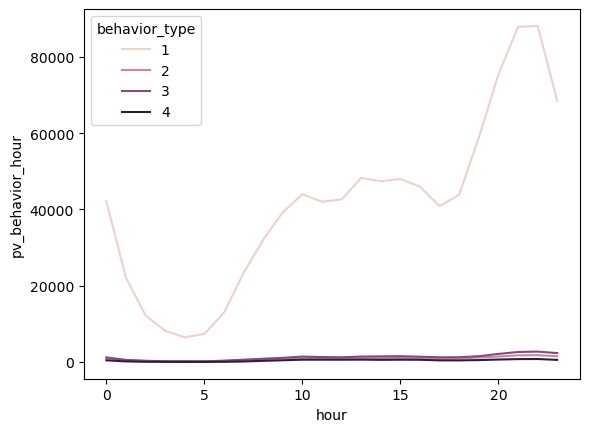

In [161]:
pv_behavior_hour = df.groupby(['behavior_type', 'hour'])['user_id'].count().reset_index().rename(columns={
    'user_id': 'pv_behavior_hour'
})

ax = sns.lineplot(x='hour', y='pv_behavior_hour', hue='behavior_type', data=pv_behavior_hour)

Visualization excluding behavior type 1

<Axes: xlabel='hour', ylabel='pv_behavior_hour'>

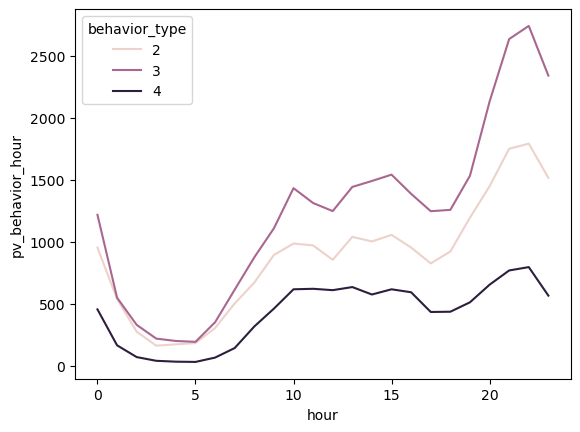

In [162]:
sns.lineplot(x='hour', y='pv_behavior_hour', hue='behavior_type', data=pv_behavior_hour[pv_behavior_hour['behavior_type'] != 1])

It can be observed that the hourly trends of the four user behaviors are generally consistent — all show a clear increase after **8:00 p.m.**, while **2:00–5:00 a.m.** remains the lowest period, which aligns with common user activity patterns.  

### **Summary and Recommendations**

**Summary:**  
Based on the above five dimensions of analysis, user activity peaks between **8:00 p.m. and 10:00 p.m.** each day, and **Thursday** records the highest weekly traffic.  
Tuesdays, Wednesdays, and the **night before Double 12 (10:00 p.m.)** also rank in the **top three** for PV.

**Recommendation:**  
Since products placed higher on the page are more likely to be viewed and purchased, it is recommended to schedule **product updates, promotions, or restocking** during these peak hours to maximize exposure.  
If using **paid advertisements** (such as banner ads or homepage highlights), focusing on these time windows could help achieve greater visibility and better conversion results.


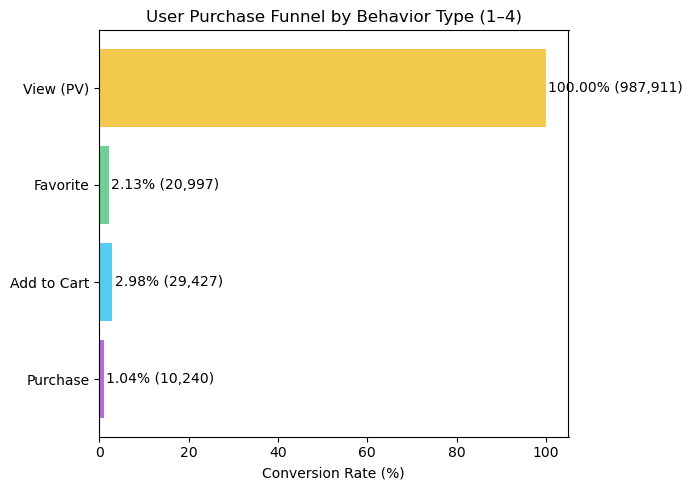

In [163]:

behavior_map = {
    1: 'View (PV)',
    2: 'Favorite',
    3: 'Add to Cart',
    4: 'Purchase'
}

behavior_counts = df['behavior_type'].value_counts().sort_index()
behavior_df = pd.DataFrame({
    'Behavior': [behavior_map[i] for i in behavior_counts.index],
    'Count': behavior_counts.values
})

behavior_df['Conversion Rate (%)'] = behavior_df['Count'] / behavior_df['Count'].iloc[0] * 100

fig, ax = plt.subplots(figsize=(7, 5))

ax.barh(
    behavior_df['Behavior'],
    behavior_df['Conversion Rate (%)'],
    color=['#F2C94C', '#6FCF97', '#56CCF2', '#BB6BD9']
)


for i, (count, rate) in enumerate(zip(behavior_df['Count'], behavior_df['Conversion Rate (%)'])):
    ax.text(rate + 0.5, i, f"{rate:.2f}% ({count:,})", va='center')

ax.invert_yaxis()  
ax.set_xlabel('Conversion Rate (%)')
ax.set_title('User Purchase Funnel by Behavior Type (1–4)')
plt.tight_layout()
plt.show()


<h2>User Preference Analysis </h2>

<h4>1. Conversion Rate Analysis </h4>

Based on the user purchase behavior funnel, we analyze the conversion at each stage:  

**Click to view product (PV)** → **Favorite or Add to Cart (fav + cart)** → **Complete Purchase (buy)**  

The visualization below shows the conversion rate of user actions by behavior type (1–4):  

From the chart, it can be observed that:  

1. **Overall conversion rate is only 1.04%**, indicating that only a small fraction of users who view products eventually complete a purchase.  
2. **The conversion from “View (PV)” to “Favorite” or “Add to Cart”** is around **5% in total** (2.10% + 2.97%), suggesting that only a limited number of users show clear purchase intent.  
3. **The conversion from “Add to Cart” to “Purchase”** is relatively higher, at around **20.5%**, meaning users who have already added items to their cart have a strong likelihood of completing the transaction.  

Overall, while user browsing activity (PV) is high, encouraging more users to move from interest (favorite/add to cart) to final purchase remains a key opportunity to improve sales conversion efficiency.


<h4>2. Relationship Between User Behavior and Product Categories </h4>

To further explore why conversion rates and favorite/add-to-cart rates are low,  
we hypothesize that the **interest recommendation system may not be accurately targeting users**.  
To verify this, we conduct an analysis of user behavior across different product categories.

In [164]:
df['operation'] = 1
df_category = (
    df[df['behavior_type'] != 2]              
      .groupby(['item_category','behavior_type'])['operation']
      .count()
      .unstack(fill_value=0)                  
      .rename(columns={1:'pv', 3:'cart', 4:'buy'}) 
)

df_category['conversion_rate_bp'] = df_category['buy'] / df_category['pv'].replace(0, pd.NA)
df_category['conversion_rate_cp(favorite_rate)'] = df_category['cart'] / df_category['pv'].replace(0, pd.NA)

df_category.head()


behavior_type,pv,cart,buy,conversion_rate_bp,conversion_rate_cp(favorite_rate)
item_category,,,,,
8,97,1,0,0.0,0.010309
10,15,1,1,0.066667,0.066667
11,739,5,0,0.0,0.006766
12,11,0,0,0.0,0.0
13,7,0,0,0.0,0.0


In [165]:
# Fill missing values
df_category = df_category.fillna(0)

# Remove abnormal values where conversion rate exceeds 100%
df_category = df_category[df_category['conversion_rate_bp'] <= 1]
df_category = df_category[df_category['conversion_rate_cp(favorite_rate)'] <= 1]

C:\Users\zheng\AppData\Local\Temp\ipykernel_18120\3786938451.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_category = df_category.fillna(0)


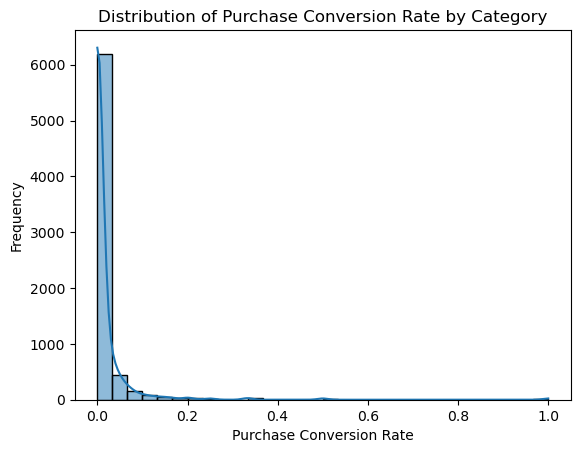

In [166]:
sns.histplot(df_category['conversion_rate_bp'], bins=30, kde=True)
plt.title('Distribution of Purchase Conversion Rate by Category')
plt.xlabel('Purchase Conversion Rate')
plt.ylabel('Frequency')
plt.show()

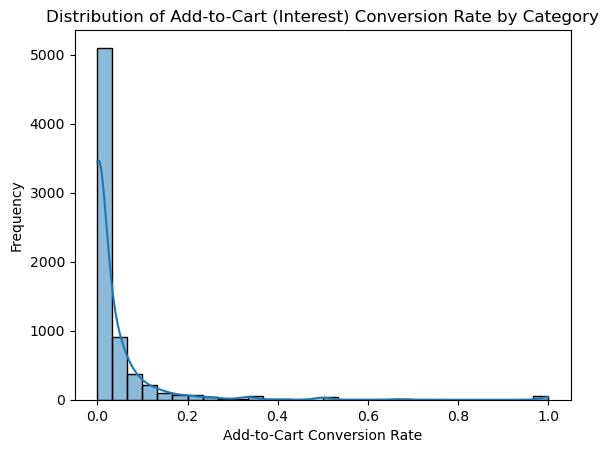

In [167]:
sns.histplot(df_category['conversion_rate_cp(favorite_rate)'], bins=30, kde=True)
plt.title('Distribution of Add-to-Cart (Interest) Conversion Rate by Category')
plt.xlabel('Add-to-Cart Conversion Rate')
plt.ylabel('Frequency')
plt.show()

In [168]:
# Classify conversion rates into three groups and analyze the proportion of each group
df_convert_rate = pd.cut(df_category['conversion_rate_bp'], [-1, 0, 0.1, 1]).value_counts()
df_convert_rate = df_convert_rate / df_convert_rate.sum()
df_convert_rate

conversion_rate_bp
(-1.0, 0.0]    0.710165
(0.0, 0.1]     0.253782
(0.1, 1.0]     0.036053
Name: count, dtype: float64

In [169]:
# Similarly, classify the interest conversion rate into three categories and calculate the proportion of each
df_interest_rate = pd.cut(df_category['conversion_rate_cp(favorite_rate)'], [-1, 0, 0.1, 1]).value_counts()
df_interest_rate = df_interest_rate / df_interest_rate.sum()
df_interest_rate

conversion_rate_cp(favorite_rate)
(-1.0, 0.0]    0.587869
(0.0, 0.1]     0.321504
(0.1, 1.0]     0.090626
Name: count, dtype: float64

Based on the above charts, both the purchase conversion rate and the interest rate of products are mostly below 0.1.  
Only **2.04%** of users have a conversion rate higher than 0.1, while over **47%** of users almost never make a purchase.  
At the same time, from the perspective of interest rate, **39%** of users show no interest in the products at all.

<h4>3. Pareto (80/20) Principle Analysis </h4>

According to the Pareto Principle, **80% of total sales typically come from 20% of the key users or products**.

Based on this rule, we can focus on adjusting the top 80% of products that contribute the most to sales.  
The following output shows the **“Top 80% Sales Product List”**:

In [170]:
df_category = df_category[df_category['buy'] > 0]

value_8 = df_category['buy'].sum() * 0.8     
value_10 = df_category['buy'].sum()          

df_category = df_category.sort_values(by='buy', ascending=False)
df_category['buy_cumsum'] = df_category['buy'].cumsum()
df_category['label'] = df_category['buy_cumsum'].map(lambda x: 'top 80%' if x <= value_8 else 'bottom 20%')
df_category.head()


behavior_type,pv,cart,buy,conversion_rate_bp,conversion_rate_cp(favorite_rate),buy_cumsum,label
item_category,,,,,,,
6344,7230,322,174,0.024066,0.044537,174,top 80%
1863,32070,804,140,0.004365,0.025070,314,top 80%
5232,11327,374,138,0.012183,0.033018,452,top 80%
3424,4298,128,110,0.025593,0.029781,562,top 80%
3472,4345,127,104,0.023936,0.029229,666,top 80%


<h4>4. Top 20 Products by Purchase Volume and Visit Volume </h4>

By combining product purchase volume and visit volume,  
we can generate a more refined list of **“Priority Recommendation Optimization Products”** as shown below:

In [171]:
buy_top20 = df_category.nlargest(20, 'buy')
pv_top20 = df_category.nlargest(20, 'pv')

# use .index and the intersection() function
categories = set(buy_top20.index).intersection(set(pv_top20.index))
categories

{1863,
 3064,
 4370,
 5027,
 5232,
 5399,
 5894,
 6344,
 6513,
 9516,
 10392,
 10894,
 11279}

It can be observed that there are 14 overlapping product categories.  
These 14 categories have both high traffic and certain conversion capabilities.  
Therefore, targeted optimization can focus on these product categories to increase conversion rates within high-traffic segments.


The overall conversion rate from user visits to purchases is only **1.04%**,  
and the conversion rate from clicks to favorites/add-to-cart actions is **5.07%**.  
Most product categories have conversion and interest rates below **0.1**,  
and only **2.04%** of users achieve conversion rates above **0.1**.  
Over **47%** of users almost never make purchases, and **39%** of users show no interest in products.  
However, for those who do express interest, the conversion rate from favorite/add-to-cart to purchase reaches **20.51%**.

**Recommendation:**  
This indicates that the overall product conversion rate remains low.  
Although the recommendation system successfully draws user interest, only a small fraction of users (around 1%) proceed to complete purchases. The operation and recommendation mechanisms should be optimized. It is suggested to combine the **“Top 80% Sales Product List”** with the **“Priority Recommendation Optimization List”**, in order to better target user preferences and fine-tune the recommendation algorithm —  ultimately improving conversion efficiency within high-value categories.


<h2>User Purchase Frequency Analysis </h2>

<h4>1. User Purchase Count </h4>

<Axes: xlabel='user_id'>

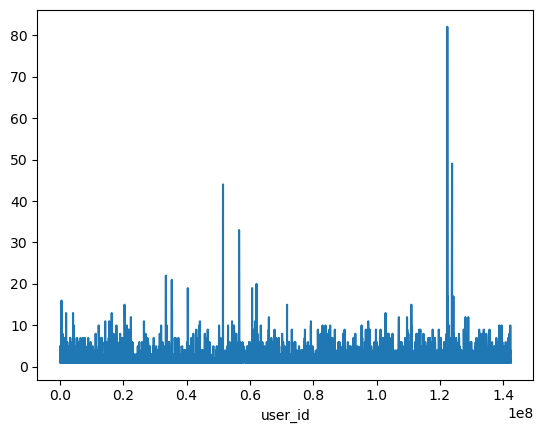

In [172]:
# Count user purchase frequency
user_buy = df[df.behavior_type == 4].groupby('user_id')['behavior_type'].count()
user_buy.plot(x='user_id', y='buy_count')

In [173]:
# Divide users’ purchase frequency into three categories and calculate their proportions
buy_rate = pd.cut(df[df.behavior_type == 4].groupby('user_id')['behavior_type'].count(),[0, 50, 600, 1000]).value_counts()

# Calculate the proportion of each group within the total dataset
buy_rate = buy_rate / buy_rate.sum()
buy_rate


behavior_type
(0, 50]        0.999769
(50, 600]      0.000231
(600, 1000]    0.000000
Name: count, dtype: float64

It can be observed that within one month:

1. **Nearly 96.7% of users made fewer than 50 purchases**, even though this period includes the shopping peak around **Double 12 (December 12)**.  
   Excluding that event, the actual purchase frequency would likely be even lower.

2. **Only about 3% of users made more than 50 purchases**, representing a group of **high-frequency and loyal users** who should be prioritized for retention and personalized engagement.

3. **A small number of users made more than 600 purchases**, and it **requires further investigation to determine whether such high-frequency purchasing behavior is abnormal or suspicious**.


<h4>2. ARPPU Analysis </h4>

ARPPU (Average Revenue Per Paying User)** represents the average revenue per paying user.

**ARPPU (Average Revenue Per Paying User)** represents the average revenue generated per paying user.  
**Formula:** ARPPU = Total Revenue / Number of Paying Users.

Since the dataset does not contain revenue data, we instead measure **the average number of purchase actions per paying user**.  
**Revised Formula:** ARPPU = Total Purchase Count / Number of Paying Users.

C:\Users\zheng\AppData\Local\Temp\ipykernel_18120\1755955688.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  arppu = user_arppu.groupby('date').apply(lambda x: x['buy_count'].sum() / x['user_id'].nunique())


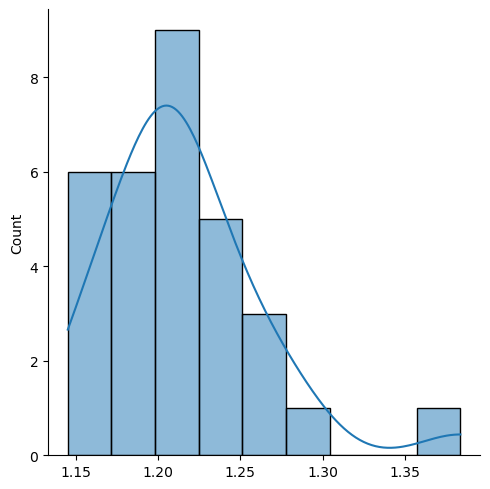

In [174]:
user_arppu = df[df['behavior_type'] == 4].groupby(['date', 'user_id'])['behavior_type'].count().reset_index(name='buy_count')
arppu = user_arppu.groupby('date').apply(lambda x: x['buy_count'].sum() / x['user_id'].nunique())

sns.displot(arppu, kde=True)

In [175]:
arppu

date
2024-11-18    1.207692
2024-11-19    1.248062
2024-11-20    1.290749
2024-11-21    1.174757
2024-11-22    1.272340
2024-11-23    1.236842
2024-11-24    1.194332
2024-11-25    1.232000
2024-11-26    1.275229
2024-11-27    1.213483
2024-11-28    1.243802
2024-11-29    1.204651
2024-11-30    1.152941
2024-12-01    1.216912
2024-12-02    1.169231
2024-12-03    1.252874
2024-12-04    1.195730
2024-12-05    1.194915
2024-12-06    1.237903
2024-12-07    1.195021
2024-12-08    1.191964
2024-12-09    1.166667
2024-12-10    1.164444
2024-12-11    1.206278
2024-12-12    1.383708
2024-12-13    1.203125
2024-12-14    1.164062
2024-12-15    1.145270
2024-12-16    1.211679
2024-12-17    1.212598
2024-12-18    1.215768
dtype: float64

It can be observed that the average daily purchase frequency fluctuates between **2 and 2.5 times**,  
while on **Double 12 Day** it exceeds **3.9**, indicating that users may add items to their carts beforehand but tend to complete their purchases collectively on the Double 12 event day.

<h4>3. Repurchase Analysis</h4>

Repurchase refers to users who made purchases on the platform on **two or more different days**.  
Multiple purchases within the same day are **not** considered repurchases.

Repurchase Rate = Number of Repurchasing Users / Number of Users Who Made Purchases.

In [176]:
user_pay = df[df.behavior_type == 4].groupby('user_id')['date'].apply(lambda x: x.nunique())
repeat_buy_ratio = user_pay[user_pay > 1].count() / user_pay.count()
repeat_buy_ratio

np.float64(0.469284064665127)

It can be observed that the repurchase rate reaches **87.17%**, which is quite high, indicating strong user stickiness and high overall satisfaction and purchasing activity on the platform.

<h4>4. Repurchase Cycle Analysis</h4>

In addition to analyzing the frequency of repurchases, it’s also important to further explore **user repurchase intentions**, to understand how long it typically takes for users to make another purchase.

In [177]:
# Count the number of purchases made by each user on different dates
user_buy = df[df.behavior_type == 4].groupby(['user_id','date'])['operation'].count().reset_index()
user_buy.head()

,user_id,date,operation
0,7591,2024-11-25,1
1,7591,2024-12-02,1
2,7591,2024-12-04,1
3,7591,2024-12-06,1
4,12645,2024-11-27,1


In [178]:
# Sort purchase dates chronologically, calculate time intervals, and remove each user's first purchase record
user_buy_date_diff = user_buy.groupby('user_id')['date'].apply(lambda x: x.sort_values().diff()[1:])
user_buy_date_diff.head()

user_id   
7591     1    7 days
         2    2 days
         3    2 days
12645    5    6 days
         6   11 days
Name: date, dtype: timedelta64[ns]

Text(0, 0.5, 'count')

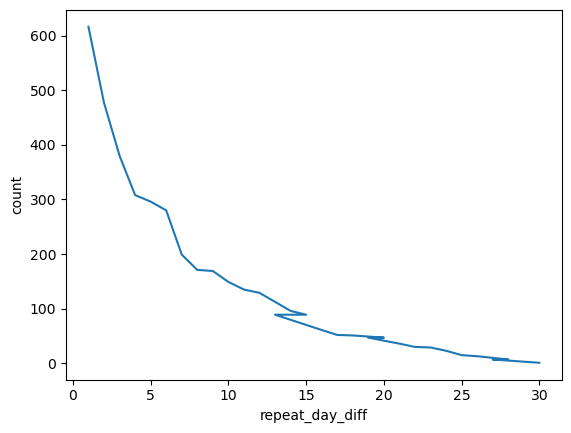

In [179]:
user_buy_date_diff = user_buy_date_diff.apply(lambda x: x.days)
user_buy_date_diff.value_counts().plot(kind='line')
plt.xlabel('repeat_day_diff')
plt.ylabel('count')

C:\Users\zheng\AppData\Local\Temp\ipykernel_18120\191125920.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_buy_date_diff.reset_index().groupby('user_id').date.mean())


<Axes: xlabel='date', ylabel='Density'>

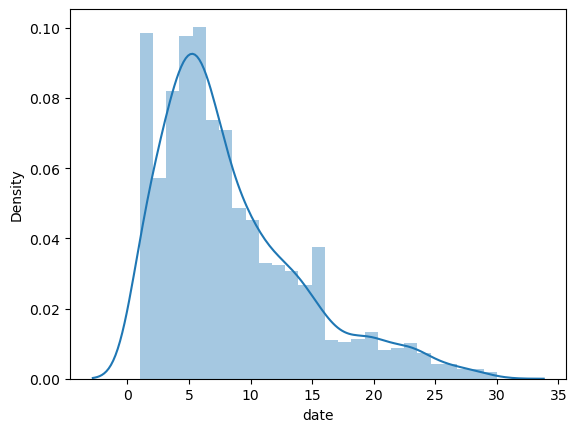

In [180]:
# Analyze the average repurchase interval for different users
sns.distplot(user_buy_date_diff.reset_index().groupby('user_id').date.mean())

It can be observed that:
1. Most users’ repurchases occur within 5 days, with a noticeable turning point appearing on the 5th day.
2. The average repurchase interval across users follows an approximately normal distribution but shows a gradual declining trend overall.  
   Most Taobao users have an average repurchase interval between 1–5 days.

**Conclusion 3:**  
Nearly 97% of users make fewer than 50 purchases. Users make an average of 2–2.5 purchases per day, with a relatively high repurchase rate of 87.17%, and the repurchase cycle is concentrated within 1–5 days.

**Recommendation 3:**  
Focus on retaining the 3% of loyal users with more than 50 purchases. Since most repurchases occur within 5 days, marketing actions should be taken during this period to increase user purchase intention.  
After 15 days, repurchase intent tends to drop to nearly zero — at this point, **recall or re-engagement strategies** should be considered to boost repurchase likelihood and reduce user churn.


## Conclusion and Recommendations

In summary, the analysis of user behavior across multiple dimensions reveals several actionable insights for optimizing e-commerce operations and marketing effectiveness.

Firstly, user activity peaks between **8:00 p.m. and 10:00 p.m.**, with the highest engagement observed on **Thursdays**, followed by **Tuesdays and Wednesdays**. Additionally, the day before major shopping events such as **Double 12** shows a significant traffic surge. It is therefore recommended that merchants adjust product listing schedules and intensify advertising efforts (e.g., *Taobao Direct Train* or *Diamond Booth*) during these high-traffic periods to maximize visibility and conversion opportunities.

Secondly, the **overall conversion rate from browsing to purchase remains low at 1.04%**, while the conversion rate from clicks to favorites or cart additions is **5.07%**. Only **2.04% of users** achieve a purchase conversion rate above 0.1, and **47% of users** rarely make purchases. Moreover, **39% of users show no interest** in the products they view. However, the conversion rate from favorites or cart additions to purchase reaches **20.51%**, suggesting that users who show interest are more likely to buy. This implies that **interest-driven engagement** plays a critical role in purchase decisions. The operations team should therefore focus on **refining recommendation systems** by leveraging the *“Top 80% Sales Product List”* and the *“Priority Recommendation Optimization List”*, ensuring more accurate targeting and improved conversion efficiency.

Finally, purchase frequency and repurchase behavior highlight the importance of retention strategies. Approximately **97% of users make fewer than 50 purchases**, and paying users average **2–2.5 purchases per day**. The **repurchase rate is relatively high (87.17%)**, with most repeat purchases occurring within **1–5 days**. It is advisable to implement **targeted retention and re-engagement campaigns** within this 5-day window to strengthen purchase intention. After **15 days**, repurchase likelihood declines sharply, indicating the optimal timing for recall-based marketing interventions aimed at reducing churn and stimulating further purchases.

Overall, this study demonstrates that optimizing **promotion timing, recommendation precision, and retention efforts** can collectively enhance user engagement, conversion efficiency, and long-term customer value within the platform.
